# Deconvolute spatial CUT&TAG data (Fig 3h-k)

In [1]:
from os import makedirs, mkdir, system
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import torch
from sys import argv
import seaborn as sns
from skbio.stats.composition import clr, ilr
import smoother
from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.models.deconv import LinearRegression, NNLS, NuSVR, DWLS, LogNormReg
from smoother.visualization import cluster_features
from matplotlib.colors import to_rgb, to_rgba

## Run NNLS deconvolution

In [2]:
def plot_col_mean(sp_score, coords):
    col_mean = [sp_score.mean(0)[coords.imagecol==col].mean() for col in coords.imagecol.unique()]
    sns.lineplot(x=range(len(col_mean)), y=col_mean)
    if sum(np.absolute(col_mean - np.mean(col_mean)) > 3*np.std(col_mean))>0:
        idx = coords.imagecol.unique()[np.absolute(col_mean - np.mean(col_mean)) > 3*np.std(col_mean)]
        print("Remove Column: {}".format(idx))
        return np.array(idx)
    else:
        return np.array([])
    
def plot_row_mean(sp_score, coords):
    row_mean = [sp_score.mean(0)[coords.imagerow==row].mean() for row in coords.imagerow.unique()]
    sns.lineplot(x=range(len(row_mean)), y=row_mean)
    if sum(np.absolute(row_mean - np.mean(row_mean)) > 3*np.std(row_mean))>0:
        idx = coords.imagerow.unique()[np.absolute(row_mean - np.mean(row_mean)) > 3*np.std(row_mean)]
        print("Remove Row: {}".format(idx)) 
        return np.array(idx)
    else:
        return np.array([])

class RunDeconvNNLS():
    def __init__(
        self, 
        sample_name, num_genes,
        data_dir = '/Users/jysumac/Projects/Smoother_paper/data/cutntag_processed/', 
        out_dir = '/Users/jysumac/Projects/Smoother_paper/results/embryo_cutntag/'
    ):
        self.data_dir = data_dir
        self.output_dir = out_dir
        self.sample_name = sample_name
        self.num_genes = num_genes
        self.coords, self.sp_score, self.ref_exp, self.ct_names = self.load_data()

        self.model_names, self.p_inf_list = self.run_deconv()
        self.save_deconv_results()

    def load_data(self):

        # spatial coordinates, num_spot x 2
        coords = pd.read_csv(f"{self.data_dir}/{self.sample_name}.coord.csv", header=0, index_col=0)

        # spatial gene activity scores (num_gene x num_spot)
        sp_score = pd.read_csv(f"{self.data_dir}/{self.sample_name}.var_gene_score.csv", header=0, index_col=0)
        
        print(sp_score.std(1))

        # single-cell derived reference count matrix, num_gene x num_celltype
        ref_exp = pd.read_csv(self.data_dir + "ref.all_genes.bycluster.csv", header=0, index_col=0)

        ct_names = np.array(ref_exp.columns)


        # keep only shared genes
        gene_names = sp_score.index.intersection(ref_exp.index)
        sp_score = sp_score.loc[gene_names]
        ref_exp = ref_exp.loc[gene_names,ct_names]

        print(f"Number of spots: {sp_score.shape[1]}")
        print(f"Number of genes: {len(gene_names)}")
        print(f"Number of celltypes: {len(ct_names)}")

        col_to_remove = plot_col_mean(sp_score, coords)
        row_to_remove = plot_row_mean(sp_score, coords)

        # filter out abnormal spots
        keep_spots = ~(coords.imagerow.isin(row_to_remove))|(coords.imagecol.isin(col_to_remove))
        sp_score = sp_score.loc[:, keep_spots]
        coords = coords.loc[keep_spots,:]
        keep_spots.to_csv(
            f"{self.data_dir}/{self.sample_name}.spotqc.csv", header=False
        )

        print(f"Number of spots after QC: {sp_score.shape[1]}")

        return coords, sp_score, ref_exp, ct_names

    def run_deconv(self):
        # convert data into torch tensor
        x = torch.tensor(self.ref_exp.values).float()
        y = torch.tensor(self.sp_score.values).float()
        # calculate spatial weight matrix
        weights = SpatialWeightMatrix()
        weights.calc_weights_knn(self.coords, k=4)
        weights.scale_by_expr(y)

        # prepare spatial loss
        spatial_loss = SpatialLoss('icar', weights, rho=0.99)


        # ### Run deconvolution

        # #### NNLS
        torch.manual_seed(20220814)

        deconv_configs = {'lr':3e-3, 'tol':1e-6, 'max_epochs':-1, 'verbose':False}
        l_sp_list = [0, 1, 3, 10]
        deconv_models = []
        model_names = [f'nnls_sp{str(l_sp)}' for l_sp in l_sp_list]

        # add NNLS models
        for l_sp in l_sp_list:
            model = NNLS()
            model.deconv(x, y, spatial_loss=spatial_loss,
                        lambda_spatial_loss=l_sp, **deconv_configs)
            deconv_models.append(model)
            
        # extract estimated celltype abundances 
        p_inf_list = [m.get_props().numpy() for m in deconv_models]

        return model_names, p_inf_list

    def save_deconv_results(self):
        res_dir = self.output_dir + '/nnls/'
        makedirs(res_dir, exist_ok=True)
        
        for name, p_inf in zip(self.model_names, self.p_inf_list):
            # save results
            np.savetxt(f"{res_dir}/{self.sample_name}_{name}.txt", p_inf)

Mir124a-2        0.713334
Mir9-3           0.688249
C130071C03Rik    0.656610
Mir124-2hg       0.627228
Mir3078          0.612087
                   ...   
Nynrin           0.220535
Lsm7             0.220498
Fibin            0.220372
Oip5             0.220199
Stradb           0.219881
Length: 500, dtype: float64
Number of spots: 2122
Number of genes: 430
Number of celltypes: 37
Remove Row: [1454 1476]
Number of spots after QC: 2041
Number of spots: 2041. Average number of neighbors per spot:  3.83.
Number of spots: 2041. Average number of neighbors per spot:  3.83.
=== Time  22.43s. Total epoch 5393. Final loss: (total) 0.171. (spatial) 0.000.
=== Time  25.94s. Total epoch 5272. Final loss: (total) 0.172. (spatial) 0.001.
=== Time  26.19s. Total epoch 5343. Final loss: (total) 0.173. (spatial) 0.002.
=== Time  24.64s. Total epoch 5404. Final loss: (total) 0.174. (spatial) 0.003.


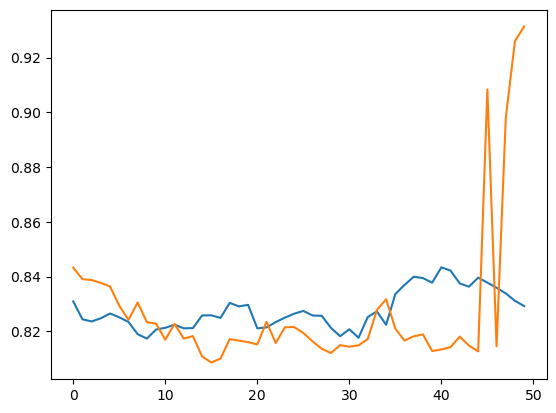

In [3]:
H3K4me3_50_top500 = RunDeconvNNLS(sample_name = 'H3K4me3.50um', num_genes=500)

## Visualization (see fig_3h-k_generate_figures.ipynb)